In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
en_dict = set(nltk.corpus.words.words())
warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid', font='monospace')

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1558 entries, 0 to 1557
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            1558 non-null   object 
 1   wins            1558 non-null   int64  
 2   kills           1558 non-null   int64  
 3   kdRatio         1558 non-null   float64
 4   killstreak      1558 non-null   int64  
 5   level           1558 non-null   int64  
 6   losses          1558 non-null   int64  
 7   prestige        1558 non-null   int64  
 8   hits            1558 non-null   int64  
 9   timePlayed      1558 non-null   int64  
 10  headshots       1558 non-null   int64  
 11  averageTime     1558 non-null   float64
 12  gamesPlayed     1558 non-null   int64  
 13  assists         1558 non-null   int64  
 14  misses          1558 non-null   int64  
 15  xp              1558 non-null   int64  
 16  scorePerMinute  1558 non-null   float64
 17  shots           1558 non-null   i

In [4]:
df['winRate']        = df['wins'] / (df['wins'] + df['losses'])
df['killsPerGame']   = df['kills'] / df['gamesPlayed']
df['deathsPerGame']  = df['deaths'] / df['gamesPlayed']
df['assistsPerGame'] = df['assists'] / df['gamesPlayed']
df['hitRate']        = df['hits'] / df['shots']
df['headshotRate']   = df['headshots'] / df['shots']
df['winRateAlt']     = df['winRate'] * np.log(df['gamesPlayed'])
df['kdRatioAlt']     = df['kdRatio'] * np.log(df['gamesPlayed'])
df.replace([np.nan, np.inf, -np.inf], 0, inplace=True)

In [5]:
from sklearn.cluster import KMeans

In [6]:
clusters = KMeans(n_clusters=4).fit(df[['winRateAlt', 'kdRatioAlt']])
df['skillTier'] = clusters.labels_
centers = [(x, y) for x, y in clusters.cluster_centers_]
centers_sorted = sorted(centers)
df['skillTier'] = df['skillTier'].apply(lambda idx: centers_sorted.index(centers[idx]) + 1)

In [7]:
for name in df['name']:
    print(name)

RggRt45#4697369
JohniceRex#9176033
bootybootykill#1892064
JNaCo#5244172
gomezyayo_007#6596687
Brxndoon7-LK#4002715
bdooory_ab#7095171
ahevepluto#3505304
MilkyLemonz-_-#5981249
RPDUNKduo#8122914
BOBOQQ3#7928912
Rachetevolution
CzarnyDelfinek#9059572
Damian291207#7986887
SanDrasoSa
DrunkUnc92#7705654
whoshotghost#1916366
Nsory_1#5583298
LimpThaDon
DeGiove#5248918
TawheedAhmed42
teruteru_yt_#6461227
edgexgaming8901#9276950
BrunoMarchione
SlaPzz#6879518
ferni775#9063204
HORUS REED#8123889
CohesiveMango93#8505922
Bobdustt#2422031
caliopez99#8569536
EH4B_367#1401846
sammy7227#7543148
WilcyWilson#2599001
URjustBADXD#7190593
DaydayLadd96#1594916
S3ND3RBUB12#9216137
Die#1566463
Jay-WKT#9248671
McWiggins14#5533106
SharkPawgin#5823839
Manuel Alarcon1#6037069
LEAN GAL#3205759
Ludsghy#4258818
Macavic#1093672
swayfaze097#4838954
Jacyków#9892624
Sir_Luffwaffles1#7708807
Grrrr pow#5106418
DeadShot1687#6299823
leandr1nho13#4383266
Blom-Tiee#6925955
Unfinishe#7062263
Passion_Divine#1903567
Sup Solaay#96

> Notice the hashtag followed by a string of numbers at the end of most names. These are *Activision IDs* that
> we shall remove from the data. There are also names with foreign characters (Korean, Japanese, Chinese etc). We
> will create a new column to denote the presence of these characters.

In [12]:
df['name']          = df['name'].apply(lambda s: re.sub(r'#\d+$', '', s).lower())
df['isEnglishName'] = df['name'].apply(lambda s: 'Yes' if s.isascii() else 'No')

In [13]:
df['nameLength'] = df['name'].apply(lambda s: len(s))

<Axes: xlabel='nameLength', ylabel='Count'>

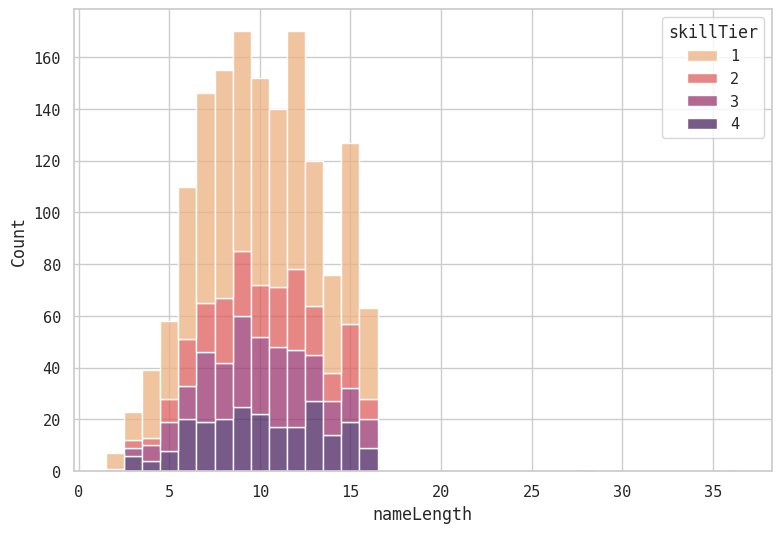

In [14]:
fig, axes = plt.subplots(1, 1, figsize=(9, 6))
sns.histplot(data=df,
             x='nameLength',
             discrete=True,
             hue='skillTier',
             palette='flare',
             multiple='stack')

<Axes: xlabel='skillTier', ylabel='Count'>

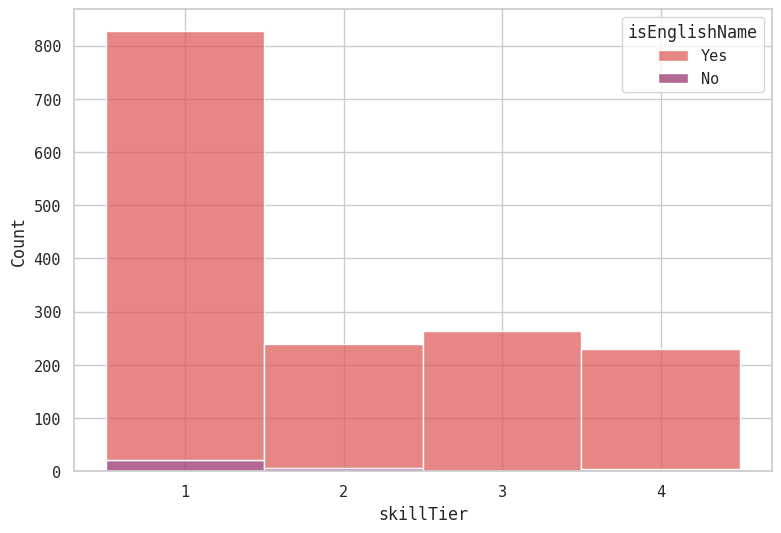

In [16]:
fig, axes = plt.subplots(1, 1, figsize=(9, 6))
axes.set_xticks(range(1, 5))
sns.histplot(data=df,
             x='skillTier',
             discrete=True,
             hue='isEnglishName',
             palette='flare',
             multiple='stack')

In [17]:
def get_en_words(s):
    return [''.join(ng) for ng in nltk.everygrams(s) if ''.join(ng).lower() in en_dict and len(''.join(ng)) >= 3]

In [18]:
sia = SentimentIntensityAnalyzer()

In [23]:
polarities = []
for i in range(len(df)):
    scores = list(map(lambda s: sia.polarity_scores(s)['compound'], get_en_words(df['name'].iloc[i])))
    if len(scores) and any(scores):
        polarities.append(min(scores) if abs(min(scores)) >= max(scores) else max(scores))
    else:
        polarities.append(np.nan)
df['namePolarities'] = polarities

<Axes: xlabel='namePolarities', ylabel='Count'>

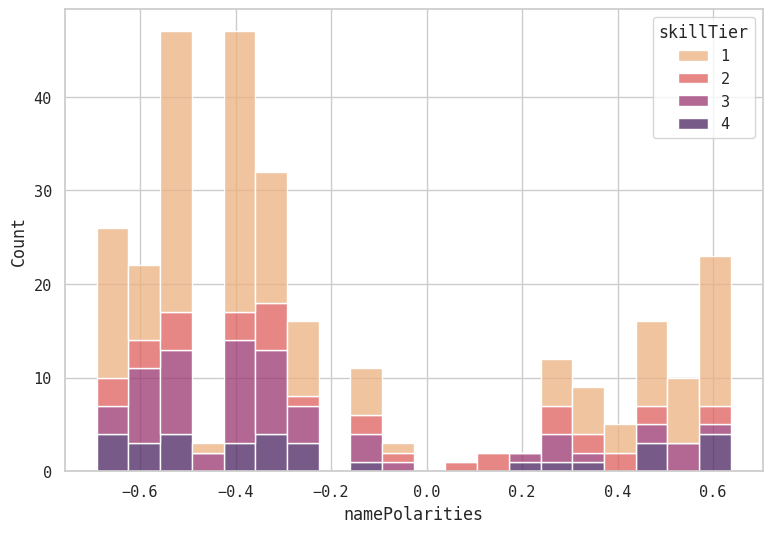

In [24]:
fig, axes = plt.subplots(1, 1, figsize=(9, 6))
sns.histplot(data=df.dropna(),
             x='namePolarities',
             hue='skillTier',
             palette='flare',
             bins=20,
             multiple='stack')